<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

<h1>Model performance and diagnostics plots<span class="tocSkip"></span></h1>

This notebook provides model type agnostic capabilities for visualizing model performance and properties weaknesses such as biases and potential omitted variables or variable transformations.

This operates on a dataset containing actuals, predictions, and other variables of interest (e.g. for examining model relationships)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<ul class="toc-item"><li><span><a href="#Import-key-libraries" data-toc-modified-id="Import-key-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import key libraries</a></span></li><li><span><a href="#Load-dataset-that-contains-a-prediction" data-toc-modified-id="Load-dataset-that-contains-a-prediction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load dataset that contains a prediction</a></span></li><li><span><a href="#Model-metrics" data-toc-modified-id="Model-metrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model metrics</a></span><ul class="toc-item"><li><span><a href="#Metrics-on-predicted-classes" data-toc-modified-id="Metrics-on-predicted-classes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Metrics on predicted classes</a></span><ul class="toc-item"><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Accuracy,-Specificity,-Sensitivity,-Precision,-Recall" data-toc-modified-id="Accuracy,-Specificity,-Sensitivity,-Precision,-Recall-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Accuracy, Specificity, Sensitivity, Precision, Recall</a></span></li><li><span><a href="#Using-sklearn's-built-in-classification-metrics-function" data-toc-modified-id="Using-sklearn's-built-in-classification-metrics-function-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Using sklearn's built in classification metrics function</a></span></li></ul></li><li><span><a href="#Probability-related-metrics" data-toc-modified-id="Probability-related-metrics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Probability related metrics</a></span><ul class="toc-item"><li><span><a href="#Receiver-Operating-Curve-(ROC),-AUC-(area-under-ROC),-and-Gini" data-toc-modified-id="Receiver-Operating-Curve-(ROC),-AUC-(area-under-ROC),-and-Gini-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Receiver Operating Curve (ROC), AUC (area under ROC), and Gini</a></span></li><li><span><a href="#Precision-Recall-plot" data-toc-modified-id="Precision-Recall-plot-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Precision Recall plot</a></span></li><li><span><a href="#Pseudo-R2-metrics" data-toc-modified-id="Pseudo-R2-metrics-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Pseudo R2 metrics</a></span></li></ul></li></ul></li><li><span><a href="#Model-performance-plots" data-toc-modified-id="Model-performance-plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model performance plots</a></span><ul class="toc-item"><li><span><a href="#Actual-vs.-Predicted-by-binned-prediction" data-toc-modified-id="Actual-vs.-Predicted-by-binned-prediction-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Actual vs. Predicted by binned prediction</a></span></li><li><span><a href="#Actual-and-Predicted-vs.-other-continuous-variables" data-toc-modified-id="Actual-and-Predicted-vs.-other-continuous-variables-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Actual and Predicted vs. other continuous variables</a></span></li><li><span><a href="#Actual-and-Predicted-vs.-other-categorical-or-discrete-variables" data-toc-modified-id="Actual-and-Predicted-vs.-other-categorical-or-discrete-variables-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Actual and Predicted vs. other categorical or discrete variables</a></span></li></ul></li><li><span><a href="#Model-performance-by-group" data-toc-modified-id="Model-performance-by-group-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model performance by group</a></span></li><li><span><a href="#Data-dictionary-(other-than-the-predictions)" data-toc-modified-id="Data-dictionary-(other-than-the-predictions)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data dictionary (other than the predictions)</a></span></li></ul>

# Import key libraries

In [1]:
# Import key libraries
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore', category=FutureWarning) # Suppress an error related to pandas

%load_ext autoreload
%autoreload 2

C:\Users\daniel.wang\AppData\Local\Temp\ipykernel_83288\4168535220.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Import code stored in the utilities folder**

In [2]:
import sys
sys.path.insert(0, "../../utilities")
from model_plots import diagnostics_categorical

# Load dataset that contains a prediction

We load a Pandas dataframe with fake loan approval data where we have the following:
* Status (which is either 0 for Approved or 1 for Declined), which we convert to "Approval" to be used as the target variable
* pred_logistic as the predictions from a logistic regression
* pred_randomforest as the predictions from a random forest model
* pred_gbm as the predictions from a GBM models

Multiple model predictions were created to enable comparisons across models.

containing the prediction "PredictedPrice". Typically, this prediction is created on the spot from a model. 

In [3]:
# Read in the data using pandas, with low_memory=False in case the dataset is large
dataset = pd.read_csv("sample_input/sample_predictions.zip", low_memory=False)

dataset = dataset.dropna(subset=["LTV"]).reset_index(drop=True) # Remove problematic data

dataset["Approval"] = 1-dataset['Status']
dataset['Approval'].value_counts()

Approval
1    27963
0     5430
Name: count, dtype: int64

**We set the probability threshold used for classification metrics to be average actual for simplicity**

In [4]:
threshold = dataset['Approval'].mean()
threshold

0.8373910699847273

**See the very bottom of this notebook for the broader data dictionary**

# Model metrics

Most of these metrics can be found here: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

Simplistically speaking, there are two types of metrics:
* Metrics that rely on the predicted probabilities
* Metrics that only make use of the predicted classes (0 or 1)

It is easy to convert probability to a class predictions, by setting an appropriate threshold. However, setting the threshold is not necessarily straightforward. By default, often 50% is used, which can be problematic if the data is unbalanced. Some like to use the average actual rate. But sometimes you need to select one based on how the model will be used (e.g. anything over 10% is to be flagged, e.g. in fraud risk purposes)


## Metrics on predicted classes

### Confusion matrix

We use `from sklearn.metrics import confusion_matrix` for this. See the function help below

In [5]:
help(diagnostics_categorical.generate_confusion_matrix)

Help on function generate_confusion_matrix in module model_plots.diagnostics_categorical:

generate_confusion_matrix(dataset, actual_col, predicted_col, threshold=0.5, totals=False, percentage=False)
    Generate a confusion matrix with options for row/column totals and percentages.
    
    Parameters:
    dataset (pd.DataFrame): Pandas DataFrame containing the actual and predicted values.
    actual_col (str): Column name for the actual binary outcomes (0 or 1).
    predicted_col (str): Column name for the predicted probabilities for the positive class.
    threshold (float, optional): Threshold for classifying a predicted probability as positive. Defaults to 0.5.
    totals (bool, optional): Whether to add row and column totals to the confusion matrix. Defaults to False.
    percentage (str or bool, optional): Whether to convert counts to percentages. If 'Row', row percentages are calculated. 
                                         If 'Column', column percentages are calculated. I

In [6]:
diagnostics_categorical.generate_confusion_matrix(dataset, 'Approval', 'pred_logistic', threshold=threshold, totals=True)

,Predicted Negative,Predicted Positive,Row Total
Actual Negative,2568,2862,5430
Actual Positive,8098,19865,27963
Column Total,10666,22727,33393


In [7]:
diagnostics_categorical.generate_confusion_matrix(dataset, 'Approval', 'pred_logistic', threshold=threshold, 
                                                  percentage='Row')

,Predicted Negative,Predicted Positive
Actual Negative,47.29%,52.71%
Actual Positive,28.96%,71.04%


### Accuracy, Specificity, Sensitivity, Precision, Recall

1. **Accuracy**: This is the proportion of true results (both true positives and true negatives) in the population. It is a measure of the correctly identified positive and negative observations to all observations. Mathematically, it's expressed as (TP+TN) / (TP+FP+FN+TN), where TP is True Positives, TN is True Negatives, FP is False Positives, and FN is False Negatives.

2. **Specificity**: Also known as the True Negative Rate, specificity measures the proportion of actual negatives that are correctly identified as such. It is the ability of the model to find all the relevant instances. Mathematically, it's expressed as TN / (TN+FP).

3. **Sensitivity**: Also known as the True Positive Rate, sensitivity measures the proportion of actual positives that are correctly identified as such. It is the ability of the model to find all the relevant instances. In other words, how good the model is at catching positives. It's also known as "recall". Mathematically, it's expressed as TP / (TP+FN).

4. **Precision**: Precision is the proportion of true positive against all the positive results (both true positives and false positives). It is a measure of amongst all the predicted positives, how many of them are actual positive observations. Mathematically, it's expressed as TP / (TP+FP).

These metrics provide a more thorough view of the model's performance by considering both the positive and negative classes, and they are especially useful in scenarios where the data is imbalanced. Depending on your use case, some of these may be more important.

In [8]:
help(diagnostics_categorical.class_metrics)

Help on function class_metrics in module model_plots.diagnostics_categorical:

class_metrics(dataset, actual_col, predicted_cols, threshold=0.5)
    Calculate Accuracy, Specificity, Sensitivity, and Precision based on actual and predicted values, and a given threshold.
    
    Parameters:
    dataset (pd.DataFrame): Pandas DataFrame containing the actual and predicted values.
    actual_col (str): Column name for the actual binary outcomes (0 or 1).
    predicted_cols (str or list of str): Column name(s) for the predicted probabilities for the positive class.
    threshold (float, optional): Threshold for classifying a predicted probability as positive. Defaults to 0.5.
    
    Returns:
    pd.DataFrame: A DataFrame with metrics as row indices and predicted_cols as column indices if a list of predicted_cols is provided.



In [9]:
diagnostics_categorical.class_metrics(dataset, 'Approval', 'pred_logistic', threshold=threshold)

,pred_logistic
Accuracy,0.671788
Specificity,0.472928
Sensitivity,0.710403
Precision,0.874070


In [10]:
diagnostics_categorical.class_metrics(dataset, 'Approval', ['pred_logistic', 'pred_randomforest', 'pred_gbm'], threshold=threshold)

,pred_logistic,pred_randomforest,pred_gbm
Accuracy,0.671788,0.732609,0.798281
Specificity,0.472928,0.516022,0.237569
Sensitivity,0.710403,0.774667,0.907163
Precision,0.874070,0.891807,0.859694


### Using sklearn's built in classification metrics function

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

In [11]:
from sklearn.metrics import classification_report
predicted_class = 1*(dataset['pred_logistic'] > threshold)  # Threshold

classification_report(dataset['Approval'], predicted_class, output_dict=True)

{'0': {'precision': 0.24076504781548846,
  'recall': 0.47292817679558014,
  'f1-score': 0.3190854870775348,
  'support': 5430.0},
 '1': {'precision': 0.8740704888458661,
  'recall': 0.7104030325787648,
  'f1-score': 0.7837837837837838,
  'support': 27963.0},
 'accuracy': 0.67178750037433,
 'macro avg': {'precision': 0.5574177683306774,
  'recall': 0.5916656046871724,
  'f1-score': 0.5514346354306593,
  'support': 33393.0},
 'weighted avg': {'precision': 0.7710893687070661,
  'recall': 0.67178750037433,
  'f1-score': 0.708219690976461,
  'support': 33393.0}}

## Probability related metrics

### Receiver Operating Curve (ROC), AUC (area under ROC), and Gini 

The Receiver Operating Characteristic (ROC) curve assess the performance of a model across all possible thresholds. It plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at various threshold settings.

The Area Under the ROC curve (AUC) is a single number summary of the ROC curve that measures the area underneath the entire ROC curve and provides an aggregate measure of performance. AUC ranges in value from 0 to 1 where a model whose predictions are 100% wrong has an AUC of 0 and one whose predictions are 100% correct has an AUC of 1. 

The Gini coefficient is another measure of a model's discriminatory power. It can be derived from the AUC as Gini = `2*AUC - 1`. A Gini coefficient of 0 represents a model with no discrimination ability, i.e., random predictions, while a Gini coefficient of 1 represents a model with perfect discrimination ability. A negative Gini indicates worse than random predictions (often a sign something has gone wrong with your model).

Note, different software use different calculation strategies. For example, it may only evaluate ROC for a certain number of thresholds, and may treat ties differently. For the Gini metric, there are several alternative methods which will be described further below.

In [12]:
help(diagnostics_categorical.get_roc_gini)

Help on function get_roc_gini in module model_plots.diagnostics_categorical:

get_roc_gini(dataset, actual_col, predicted_cols, figsize=(6, 4))
    This function calculates and plots the ROC curves for one or more predicted columns, 
    and also calculates the AUC and Gini coefficient for each.
    
    Parameters:
    dataset (pandas.DataFrame): The dataset containing the actual and predicted values.
    actual_col (str): The name of the column in the dataset that contains the actual values.
    predicted_cols (str or list of str): The name(s) of the column(s) in the dataset that contains the predicted values.
    figsize (tuple): figure size
    
    Returns:
    fig (matplotlib.figure.Figure): The ROC plot.
    metrics_df (pandas.DataFrame): A DataFrame containing the AUC and Gini coefficient for each predicted column.



(<Figure size 600x400 with 1 Axes>,
                         AUC      Gini
 pred_logistic      0.617912  0.235823
 pred_randomforest  0.698321  0.396642
 pred_gbm           0.625266  0.250533)

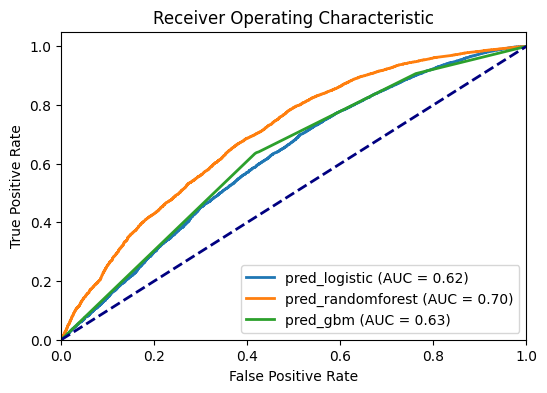

In [13]:
diagnostics_categorical.get_roc_gini(dataset, 'Approval', ['pred_logistic', 'pred_randomforest', 'pred_gbm'])

**Another way to calculate Gini (twice the value of Somers's D)**

Somers' D is a measure of rank correlation between predicted and actual binary outcomes. It measures the degree of agreement between two rankings. The value of Somers' D ranges from -1 to 1, where 1 indicates perfect agreement, -1 indicates perfect disagreement, and 0 indicates no association.

Somers D is available through `from statsmodels.stats.stattools import somersd`. A custom function is shown below.

In [14]:
from scipy.stats import rankdata

def somers_d(y_true, y_pred):
    # Calculate ranks
    y_true_rank = rankdata(y_true)
    y_pred_rank = rankdata(y_pred)

    # Calculate concordant and discordant pairs
    concordant = np.sum((y_true_rank - y_true_rank.mean()) * (y_pred_rank - y_pred_rank.mean()) > 0)
    discordant = np.sum((y_true_rank - y_true_rank.mean()) * (y_pred_rank - y_pred_rank.mean()) < 0)

    # Calculate Somers' D
    somers_d = (concordant - discordant) / (concordant + discordant)

    return somers_d

# y_true and y_pred are the actual and predicted outcomes, respectively
somers_d(dataset['Approval'], dataset['pred_logistic'])

0.08804504072831816

**Multiplying this with 2 gives us the alternative Gini metric**

### Precision Recall plot

Precision: "Out of all the instances the classifier labeled as positive, how many are actually positive?"
Recall: "Out of all the actual positive instances, how many did the classifier correctly identify?"

PR plots is similar to the ROC plot, but with different axes, and are particularly useful when dealing with imbalanced datasets, where the negative class (majority class) significantly outnumbers the positive class (minority class).

In [15]:
help(diagnostics_categorical.plot_pr_curve)

Help on function plot_pr_curve in module model_plots.diagnostics_categorical:

plot_pr_curve(dataset: pandas.core.frame.DataFrame, actual_col: str, predicted_cols: list, figsize=(6, 4))
    Plots the Precision-Recall curve and calculates the area under the curve.
    
    Parameters:
    dataset (pd.DataFrame): The dataset containing the actual outcomes and predicted probabilities.
    actual_col (str): The name of the column in the dataset containing the actual outcomes.
    predicted_cols (list): A list of names of columns in the dataset containing the predicted probabilities.
    figsize (tuple, optional): The size of the plot. Defaults to (6,4).
    
    Returns:
    fig (matplotlib.figure.Figure): The figure containing the Precision-Recall curve.
    pr_auc (dict): A dictionary where the keys are the names of the predicted_cols and the values are the corresponding area under the Precision-Recall curve.



(<Figure size 600x400 with 1 Axes>,
 {'pred_logistic': 0.8762531773527484,
  'pred_randomforest': 0.9095290474490965,
  'pred_gbm': 0.9154744990720164})

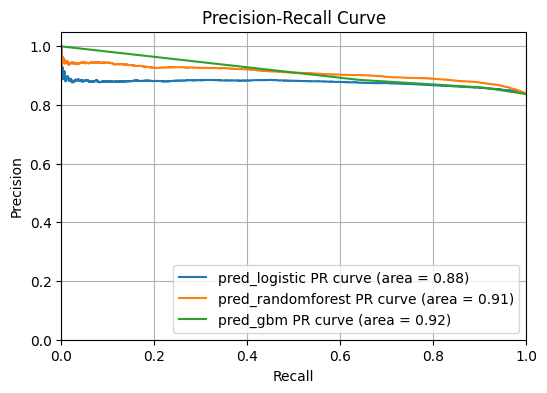

In [16]:
diagnostics_categorical.plot_pr_curve(dataset, 'Approval', ['pred_logistic', 'pred_randomforest', 'pred_gbm'])

### Pseudo R2 metrics

McFadden's and Efron's pseudo R-squared values are statistical measures used to assess the goodness of fit of a logistic regression model. 

McFadden's pseudo R-squared is calculated as 1 minus the ratio of the log-likelihood of the fitted model to the log-likelihood of the null model (a model with no predictors). A value closer to 1 indicates a better fit. 

Efron's pseudo R-squared, on the other hand, is a measure of the proportional reduction in prediction error and is calculated as 1 minus the sum of squared differences between actual and predicted outcomes divided by the sum of squared differences between actual outcomes and their mean. Like McFadden's, a value closer to 1 indicates a better fit. 

Both measures provide a way to quantify the improvement of a given model over a null model, but neither can be interpreted as the proportion of variance explained, as in the case of the traditional R-squared in linear regression.

In [17]:
help(diagnostics_categorical.calculate_pseudo_r2)

Help on function calculate_pseudo_r2 in module model_plots.diagnostics_categorical:

calculate_pseudo_r2(actual, predicted_prob)
    This function calculates McFadden's and Efron's pseudo R-squared values.
    
    Parameters:
    actual (numpy array): A numpy array of actual outcomes.
    predicted_prob (numpy array): A numpy array of predicted probabilities.
    
    Returns:
    result (dict): A dictionary with McFadden's and Efron's pseudo R-squared values.



In [18]:
diagnostics_categorical.calculate_pseudo_r2(dataset['Approval'], dataset['pred_logistic'])

{'r_squared_mcfadden': 0.9853633381111179,
 'r_squared_efron': 0.02703061104290505}

# Model performance plots

## Actual vs. Predicted by binned prediction

This chart buckets the data based on the predicted value (from low to high), and plots a scatterplot of the average actual vs. average predicted in each bucket. This allows us to bucket the actual 0 and 1 data into a rate, and make biases in the model more visually clear by smoothing out variation in errors.

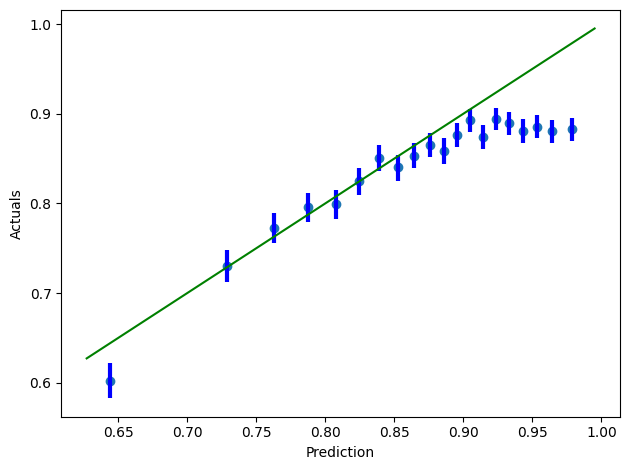

In [19]:
fig, axs, plot_data = diagnostics_categorical.act_vs_pred_plot(used_data = dataset, 
                                                              actual_var = "Approval", 
                                                              pred_var = "pred_logistic", 
                                                              num_buckets=20, 
                                                              with_count = False, 
                                                              with_CI = True, 
                                                              non_nan = True)

**There is a clear non linearity problem. Some variables need to be transformed**

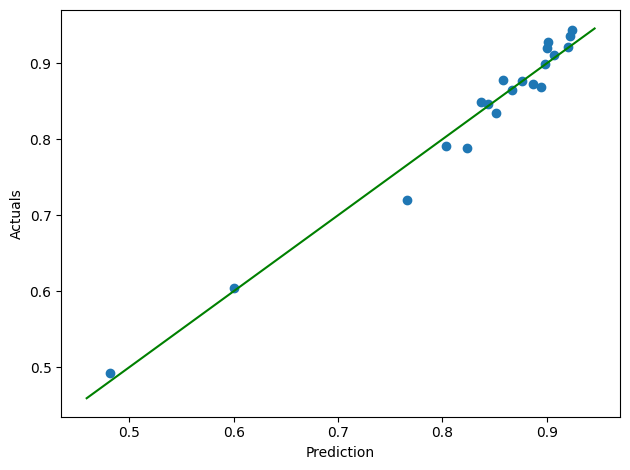

In [20]:
fig, axs, plot_data = diagnostics_categorical.act_vs_pred_plot(used_data = dataset, 
                                                              actual_var = "Approval", 
                                                              pred_var = "pred_randomforest", 
                                                              num_buckets=20, 
                                                              with_count = False, 
                                                              with_CI = False, 
                                                              non_nan = True)

### Multiple models on same plot

This code doesn't yet return a table, just a plot

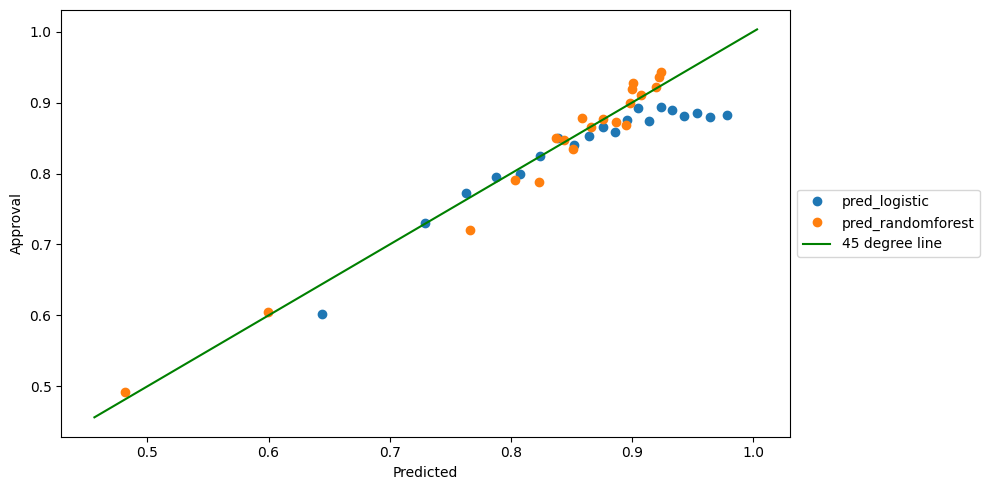

In [21]:
fig, axs = diagnostics_categorical.act_vs_pred_plot_multi(used_data = dataset, 
                                                          actual_var = "Approval", 
                                                          pred_vars = ["pred_logistic","pred_randomforest"],
                                                          num_buckets=20, 
                                                          with_count = False, 
                                                          with_CI = False, 
                                                          non_nan = True,
                                                          figsize = (10,5))

## Actual and Predicted vs. other continuous variables

This chart buckets the data based on the value (from low to high) of any continuous variable, and plots the average actual and average predicted vs. the average value of the continuous variable for each bucket. This identifies biases in the model against the continuous variable to possible identify: 
* Whether the continuous variable should be added to the model (if it is not already)
* Whether a transformation of the variable should be added to the model


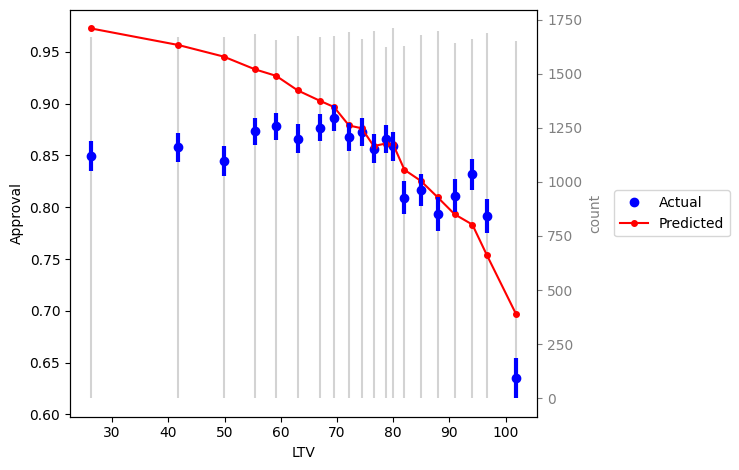

In [22]:
x_variable = "LTV"

fig, axs, plot_data = diagnostics_categorical.model_comparison_continuous(used_data = dataset, 
                                                                         actual_var = "Approval", 
                                                                         pred_var = "pred_logistic", 
                                                                         x_var = x_variable, 
                                                                         num_buckets=20, 
                                                                         y_scale="linear", x_scale="linear",
                                                                         with_count=True, 
                                                                         with_CI = True,
                                                                         non_nan = True)

**This is a clear example of transformation needed. LTV below 70 doesn't have further impact. If this variable is in the model, it needs to be floored**

**Now we check it for the random forest model**

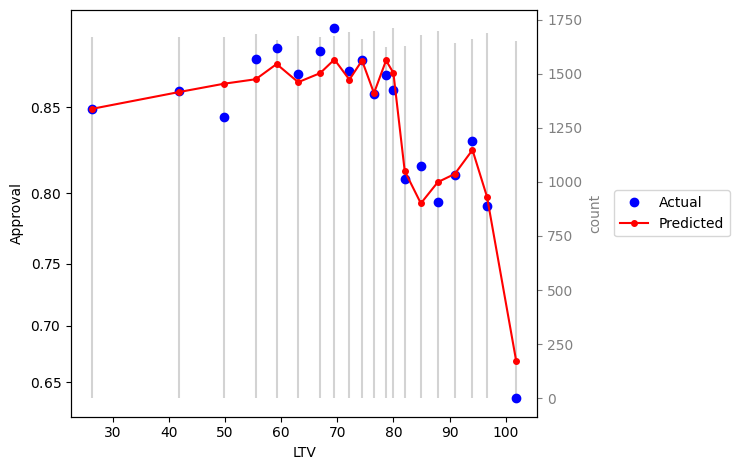

In [23]:
x_variable = "LTV"

fig, axs, plot_data = diagnostics_categorical.model_comparison_continuous(used_data = dataset, 
                                                                         actual_var = "Approval", 
                                                                         pred_var = "pred_randomforest", 
                                                                         x_var = x_variable, 
                                                                         num_buckets=20, 
                                                                         y_scale="logit", x_scale="linear",
                                                                         with_count=True, 
                                                                         with_CI = False,
                                                                         non_nan = True)

### Multiple models on the same plot

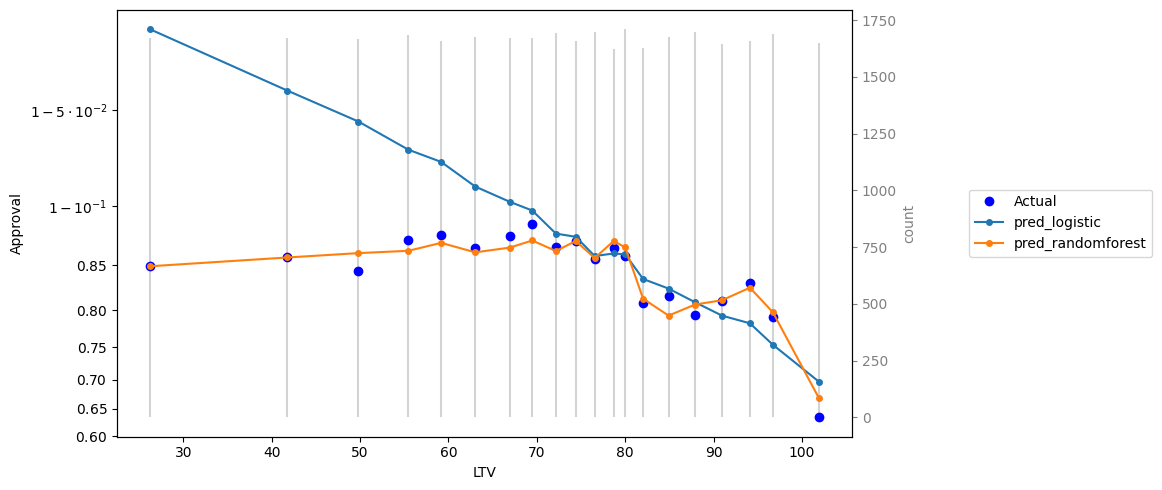

In [24]:
x_variable = "LTV"

fig, axs = diagnostics_categorical.model_comparison_continuous_multi(used_data = dataset, 
                                                                     actual_var = "Approval", 
                                                                     pred_vars = ["pred_logistic","pred_randomforest"], 
                                                                     x_var = x_variable, 
                                                                     num_buckets=20, 
                                                                     y_scale="logit", x_scale="linear",
                                                                     with_count=True, 
                                                                     with_CI = False,
                                                                     non_nan = True,
                                                                     figsize=(10, 5))

## Actual and Predicted vs. other categorical or discrete variables

This chart buckets the data based on each value of any categorical / discrete variable, and plots the average actual and average predicted for each unique value. This can identify potential biases for certain categories (if this variable is not part of the model).

Use discrete = True for numerical variables if you want to preserve the distance between values on the x-axis.

**Categorical example**

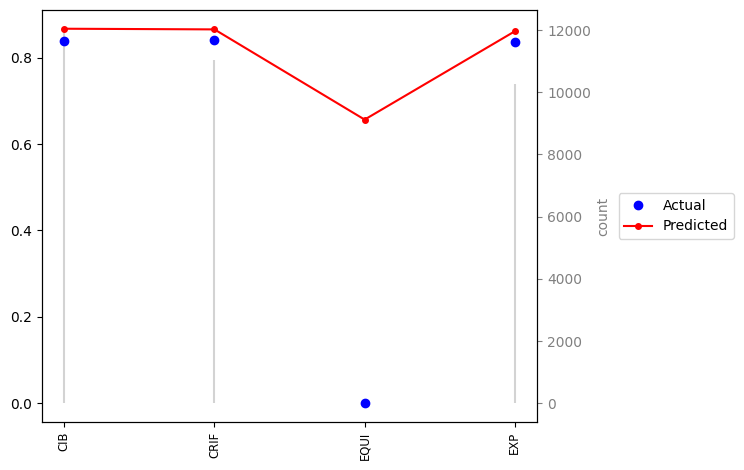

In [25]:
x_variable = "credit_type"

fig, axs, plot_data = diagnostics_categorical.model_comparison_categorical(used_data = dataset, 
                                                                         actual_var = "Approval", 
                                                                         pred_var = "pred_logistic", 
                                                                         x_var = x_variable, 
                                                                         discrete=False,
                                                                         y_scale="linear", 
                                                                         with_count=True,
                                                                         with_CI = False,
                                                                         lower=0.05, upper=0.95, non_nan = True)

This indicates that the model should use Is EQUI as an extra variable.

**Discrete example**

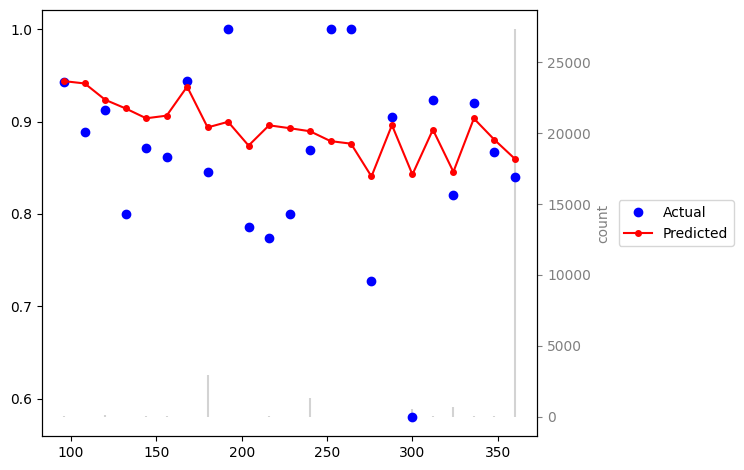

In [26]:
x_variable = "term"

fig, axs, plot_data = diagnostics_categorical.model_comparison_categorical(used_data = dataset, 
                                                                         actual_var = "Approval", 
                                                                         pred_var = "pred_logistic", 
                                                                         x_var = x_variable, 
                                                                         discrete=True,
                                                                         y_scale="linear", 
                                                                         with_count=True,
                                                                         with_CI = False,
                                                                         lower=0.05, upper=0.95, non_nan = True)

### Multiple models on the same plot

In [27]:
import sys
sys.path.insert(0, "../../utilities")
from model_plots import diagnostics_categorical

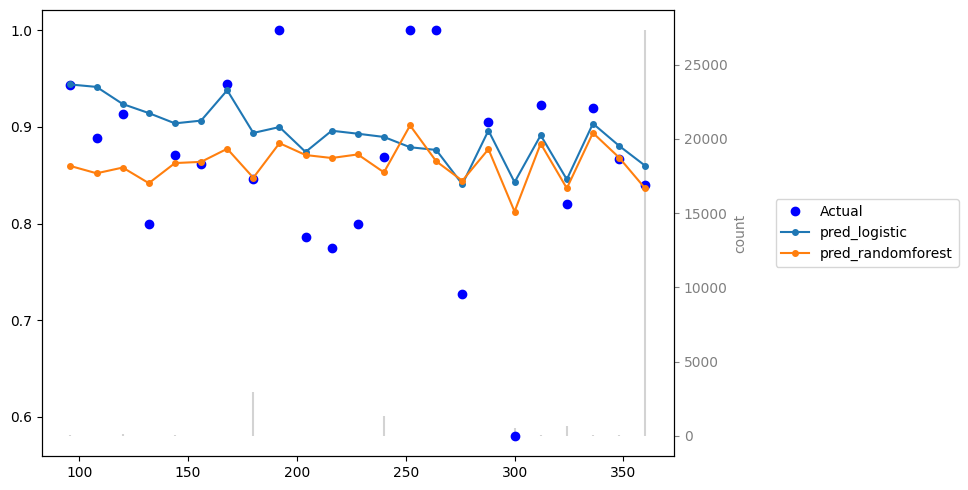

In [28]:
x_variable = "term"

fig, axs = diagnostics_categorical.model_comparison_categorical_multi(used_data = dataset, 
                                                                      actual_var = "Approval", 
                                                                      pred_vars = ["pred_logistic","pred_randomforest"], 
                                                                      x_var = x_variable, 
                                                                      discrete=True,
                                                                      y_scale="linear", 
                                                                      with_count=True,
                                                                      with_CI = False,
                                                                      lower=0.05, upper=0.95, non_nan = True,
                                                                      figsize=(10, 5))

# Model performance by group

To identify potential differences in model performance by subpopulation, the plots in the prior section can be compared across subpopulations. If there are major differences by subpopulation, interaction terms may be warranted. 

If you want to create segments from a numerical variable, you will need to convert it to a categorical variable, either by specifying your own mapping or using quantiles. We'll show an example below.

## Create a categorical segment variable from numeric variable

We use pd.cut, with manually specified cut points and with quantiles. Note that we add '.astype(str)' so that the columns are seen as character (rather than formally a categorical variable) so they remain flexible for purposes of plotting (where we will add a missing bucket)

In [29]:
# Adjust the bins to include all possible values
bins = [-float('inf'), 0, 100000, 250000, 500000, float('inf')]
labels = ['<0', '0-100k', '100k-250k', '250k-500k', '>500k']

# Use pd.cut with the adjusted bins and labels
dataset['loan_amount_bin'] = pd.cut(dataset['loan_amount'], bins=bins, labels=labels, include_lowest=True).astype(str)
dataset['loan_amount_bin'].value_counts()

loan_amount_bin
250k-500k    15215
100k-250k    11385
>500k         5241
0-100k        1552
Name: count, dtype: int64

In [30]:
# Using quantiles
dataset['loan_amount_quartiles'] = pd.qcut(dataset['loan_amount'], q=4, precision=0).astype(str)
dataset['loan_amount_quartiles'].value_counts()

loan_amount_quartiles
(26499.0, 196500.0]      8528
(196500.0, 296500.0]     8373
(296500.0, 436500.0]     8336
(436500.0, 2606500.0]    8156
Name: count, dtype: int64

**Watch out for missing values that don't get bucketed**

For convenience, our following code will automatically bucket missing values

## Actual vs. Predicted

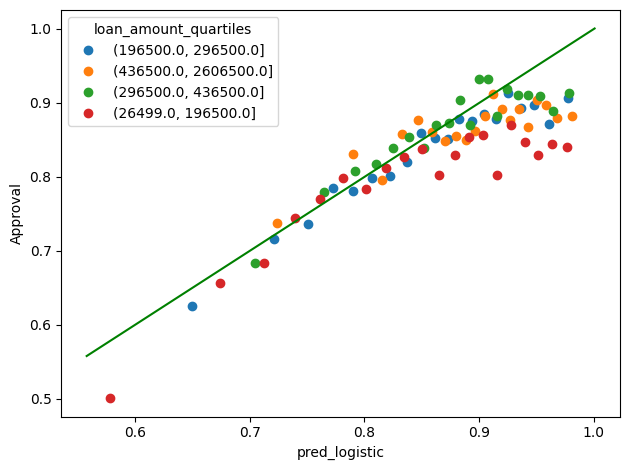

In [31]:
fig, axs, plot_data = diagnostics_categorical.act_vs_pred_plot_segmented(used_data = dataset, 
                                                                         actual_var = "Approval", 
                                                                         pred_var = "pred_logistic",
                                                                         segment = "loan_amount_quartiles",
                                                                         num_buckets=20, 
                                                                         non_nan = True)

## Actual and Predicted vs. other continuous variable

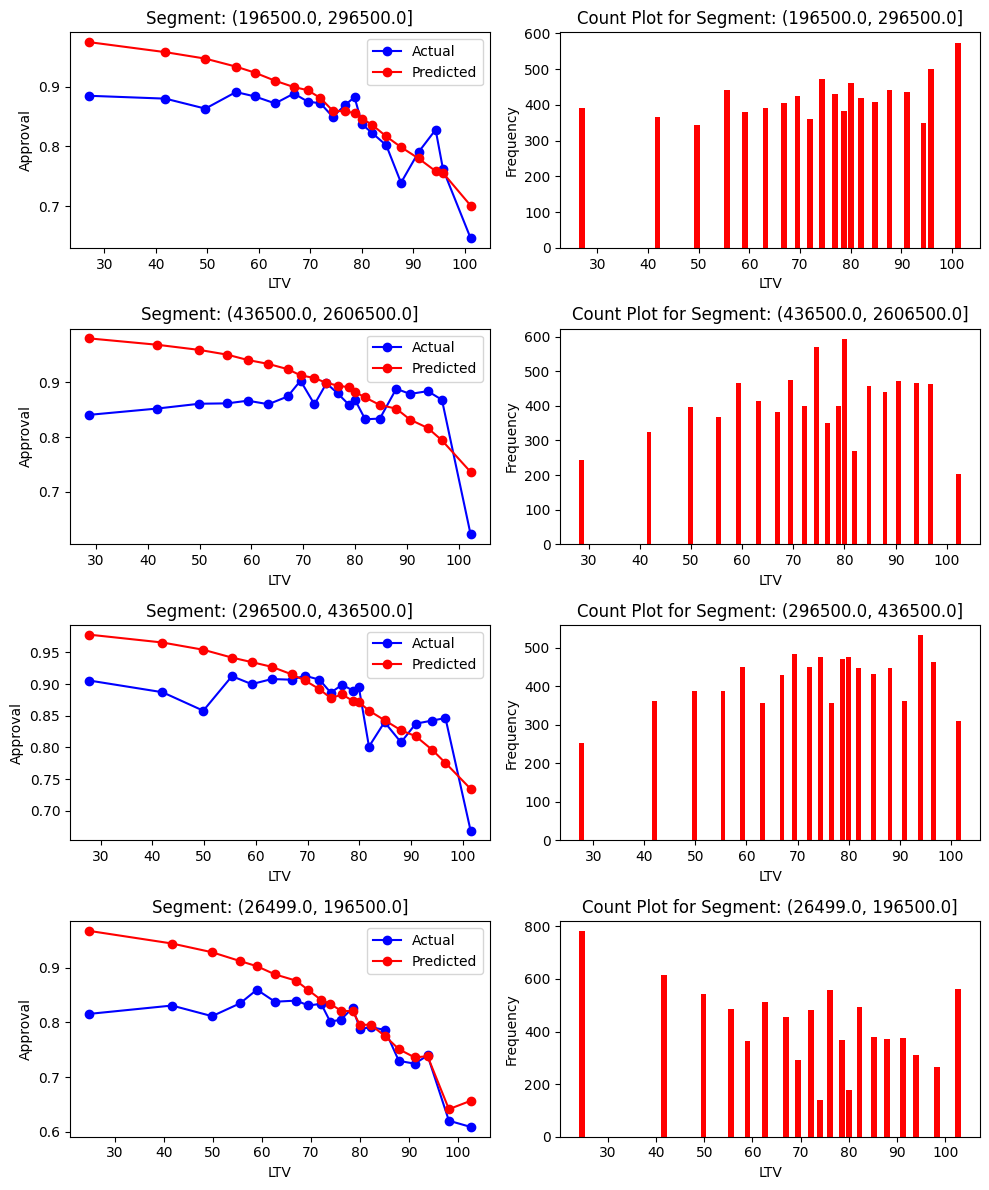

In [32]:
x_variable = "LTV"

fig, axs, plot_data = diagnostics_categorical.model_comparison_continuous_segmented(used_data = dataset, 
                                                                                    actual_var = "Approval", 
                                                                                    pred_var = "pred_logistic", 
                                                                                    x_var = x_variable, 
                                                                                    segment = "loan_amount_quartiles",
                                                                                    num_buckets=20, 
                                                                                    y_scale="linear", x_scale="linear",
                                                                                    with_count=True, 
                                                                                    non_nan = True)

## Actual and Predicted vs. other categorical or discrete variable

In [33]:
import sys
sys.path.insert(0, "../../utilities")
from model_plots import diagnostics_categorical

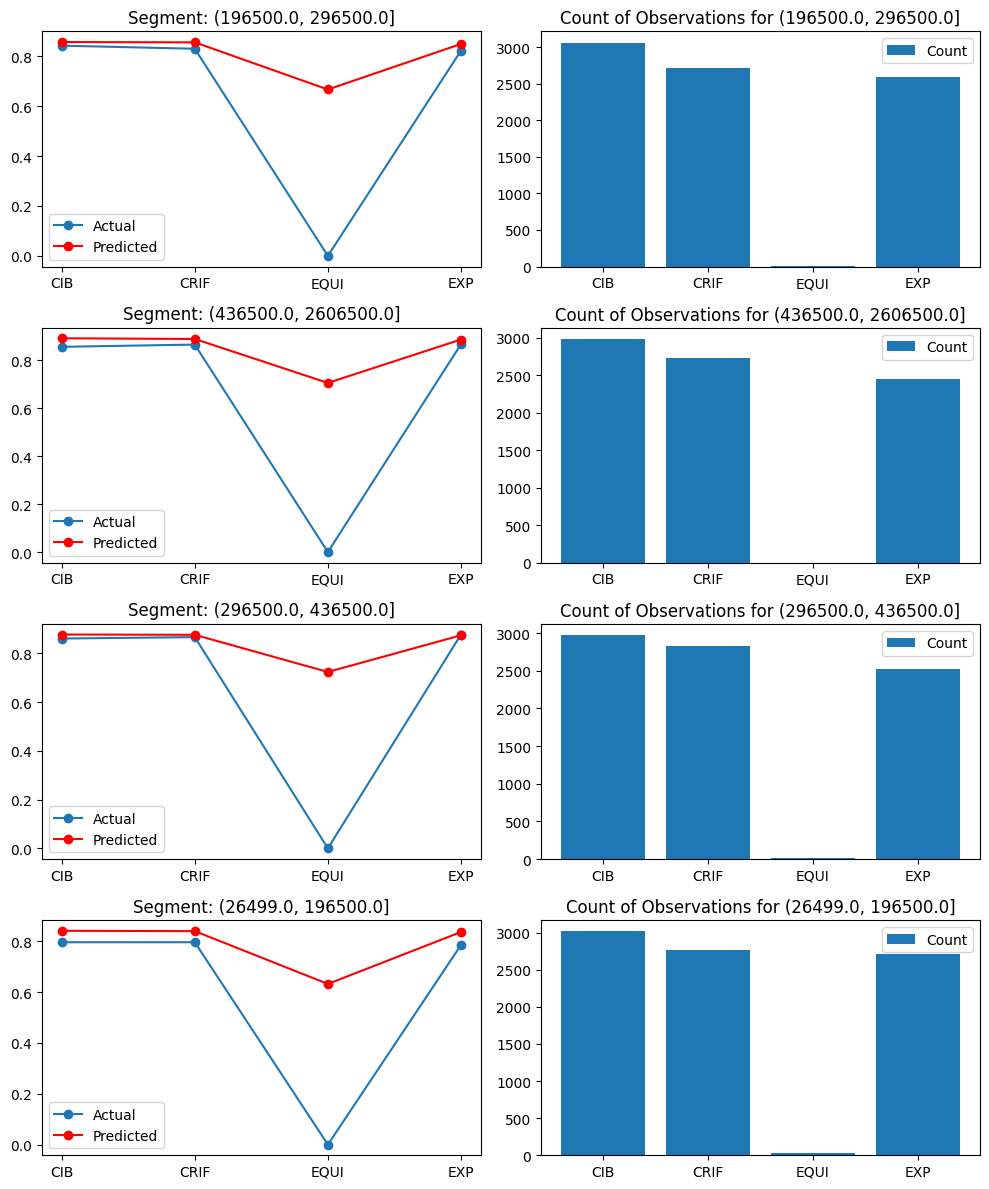

In [34]:
x_variable = "credit_type"

fig, axs, plot_data = diagnostics_categorical.model_comparison_categorical_segmented(used_data = dataset, 
                                                                                     actual_var = "Approval", 
                                                                                     pred_var = "pred_logistic", 
                                                                                     x_var = x_variable, 
                                                                                     segment = "loan_amount_quartiles",
                                                                                     discrete=False,
                                                                                     y_scale="linear", 
                                                                                     with_count=True,
                                                                                     non_nan = True)

# Data dictionary (other than the predictions)


* ID = Customer ID of Applicant
* year = Year of Application
* loan limit = maximum avaliable amount of the loan allowed to be taken
* Gender = sex type
* approv_in_adv = Is loan pre-approved or not
* loan_type = Type of loan
* loan_purpose = the reason you want to borrow money
* Credit_Worthiness = is how a lender determines that you will default on your debt obligations, or how worthy you are to receive new credit.
* open_credit = is a pre-approved loan between a lender and a borrower. It allows the borrower to make repeated withdrawals up to a certain limit.
* business_or_commercial = Usage type of the loan amount
* loan_amount = The exact loan amount
* rate_of_interest = is the amount a lender charges a borrower and is a percentage of the principal—the amount loaned.
* Interest_rate_spread = the difference between the interest rate a financial institution pays to depositors and the interest rate it receives from loans
* Upfront_charges = Fee paid to a lender by a borrower as consideration for making a new loan
* term = the loan's repayment period
* Neg_ammortization = refers to a situation when a loan borrower makes a payment less than the standard installment set by the bank.
* interest_only = amount of interest only without principles
* lump_sum_payment = is an amount of money that is paid in one single payment rather than in installments.
* property_value = the present worth of future benefits arising from the ownership of the property
* construction_type = Collateral construction type
* occupancy_type = classifications refer to categorizing structures based on their usage
* Secured_by = Type of Collatoral
* total_units = number of units
* income = refers to the amount of money, property, and other transfers of value received over a set period of time
* credit_type = type of credit
* co-applicant_credit_type = is an additional person involved in the loan application process. Both applicant and co-applicant apply and sign for the loan
* age = applicant's age
* submission_of_application = Ensure the application is complete or not
* LTV = life-time value (LTV) is a prognostication of the net profit
* Region = applicant's place
* Security_Type = Type of Collatoral
* Status = Loan status (Approved/Declined)
* dtir1 = debt-to-income ratio